In [2]:
import numpy as np
from numpy import polyfit
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, least_squares
from scipy.stats import linregress
from math import floor
from pathlib import Path
import json
from matplotlib.backends.backend_pdf import PdfPages

__rows = 1
__cols = 1


def sb_init( cols, rows):
    fig = plt.figure(figsize=[cols*5, rows*4])
    global __rows
    global __cols
    __rows = rows
    __cols = cols
    plt.subplot(rows, cols, 1)
    return fig


def sb(x, y):
    return plt.subplot(__rows, __cols, x + (y - 1) * __cols)

In [7]:
# Data saving path
savepath = "A03_results_critexpo_plots"

##  Critical exponent studies

In [11]:
# Load data

def load( filename ):
    text = filename.read_text()
    text = text.replace("nan","0")
    text = text.replace("False", "false" )
    text = text.replace("True", "true" )
    text = text.replace(",]", "]" )
    return json.loads( text )


# Load the big stuff ( side >= 1024 ) from the oldest dataset
p = Path('../data/CriticalExpoFull/')
dirs = [f for f in p.iterdir() if f.is_dir()]
data = []

for d in dirs:
    item = {}
    item.update( load( d / 'details.txt'     ) )
    if( item['side'] < 1024 ):
        continue
    item.update( load( d / 'deposition.txt'  ) )
    item.update( load( d / 'percolation.txt' ) )
    data.append(item)

# Load smaller stuff from first cloudveneto computation
p = Path('../CloudVenetoAnalysis/20220304_Delta_SmallSide_20220304/')
dirs = [f for f in p.iterdir() if f.is_dir()]

for d in dirs:
    item = {}
    item.update( load( d / 'details.txt'     ) )
    item.update( load( d / 'deposition.txt'  ) )
    item.update( load( d / 'percolation.txt' ) )
    data.append(item)

In [12]:
# useful data
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

polys = np.unique(  [i['dep_polymers'] for i in data] )
Fsides =  np.unique( [i['side'] for i in data] )
sides

array([  64,  128,  256, 1024, 2048, 4096])

### Delta

$ \Delta \coloneqq \sqrt{ <{ p_j^2 }> - <{ p_j }^2> } $

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


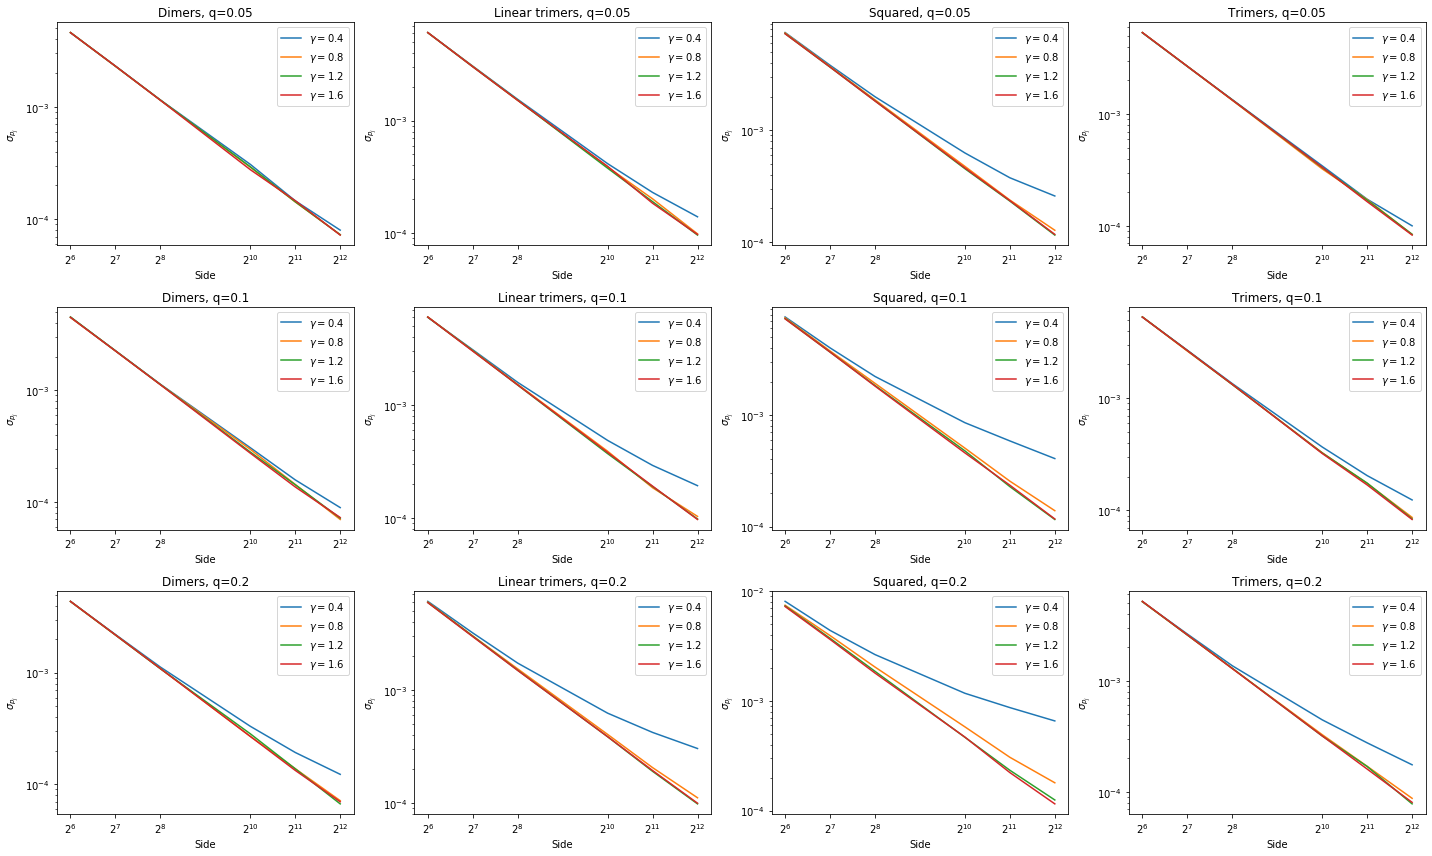

In [13]:
# Jamming density standard deviation as function of L for different values of gamma in different q and different shapes

fig = sb_init( len( polys ), len( qs ) )

ylims_1 = [ 0, 1 ]
ylims_2 = [ 0, 1 ]

for i_p, p in enumerate( polys ):
    for i_q, q in enumerate( qs ):
        axes = sb( i_p+1, i_q+1 )
        for i_gamma, gamma in enumerate( gammas ):
            x = np.array([ v['side']                    for v in data if v['dep_polymers'] == p and  v['defects_frac'] == q and  v['gamma'] == gamma ])
            y = np.array([ v['occupation_fraction_std'] for v in data if v['dep_polymers'] == p and  v['defects_frac'] == q and  v['gamma'] == gamma ])
            sort_idx = np.argsort( x )
            plt.loglog( x[sort_idx], y[sort_idx], color=color_list[ i_gamma ], label= r'$\gamma=$' + str(gamma), basex = 2, basey = 10 )
        plt.title( p + ", q=" + str(q) )
        plt.legend()
        plt.xlabel(r'Side')
        plt.ylabel(r'$\sigma_{p_j}$')
        plt.xticks( sides )

plt.tight_layout()

plt.savefig( savepath + "/Delta.pdf")

Assume $\Delta(L) = AL^{-1/\nu} + B $

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


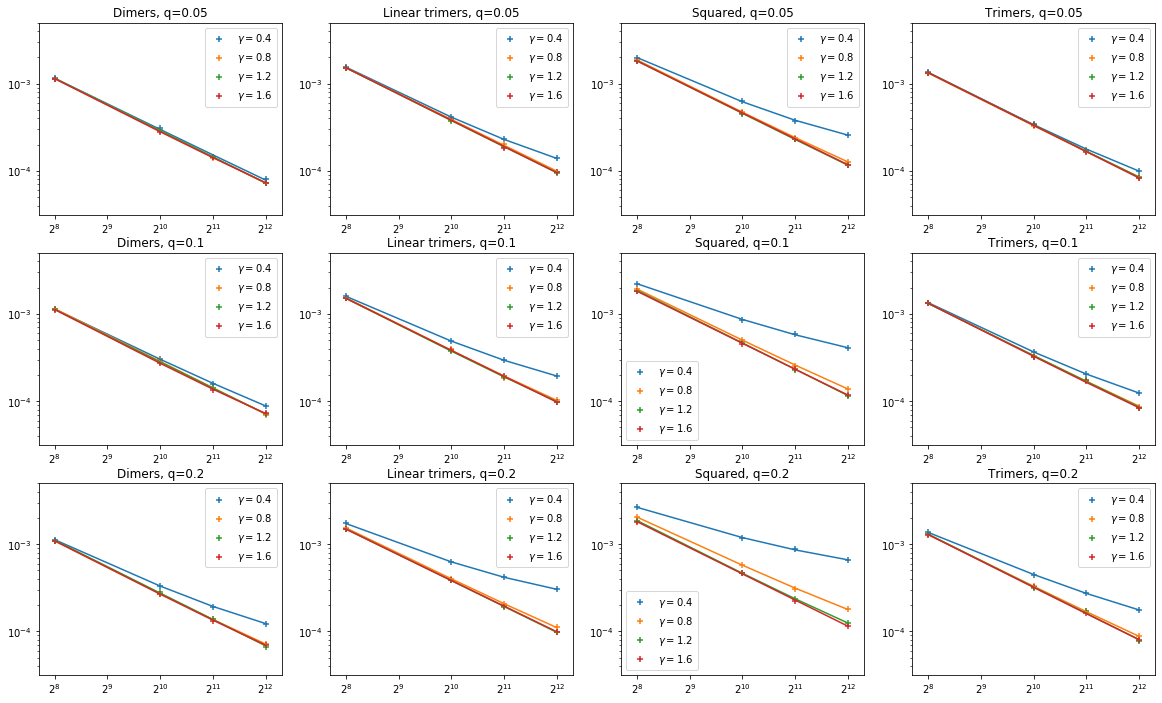

In [15]:
# Fits

fig = sb_init( len( polys ), len( qs ) )

ylims_1 = [ 0, 1 ]
ylims_2 = [ 0, 1 ]

fit_results = []

for i_p, p in enumerate( polys ):
    for i_q, q in enumerate( qs ):
        axes = sb( i_p+1, i_q+1 )
        for i_gamma, gamma in enumerate( gammas ):
            x = np.array([ v['side']                    for v in data if v['dep_polymers'] == p and  v['defects_frac'] == q and  v['gamma'] == gamma ])
            y = np.array([ v['occupation_fraction_std'] for v in data if v['dep_polymers'] == p and  v['defects_frac'] == q and  v['gamma'] == gamma ])
            
            sort_idx = np.argsort( x )
            x = x[sort_idx]
            y = y[sort_idx]

            ## Esclude small sizes
            y = y[ x > 2**7 ]
            x = x[ x > 2**7 ]

            ## Iterative fit
            ### Initial values
            [menounosunu, log2A], covmat = polyfit( np.log2(x), np.log2(y), 1, cov = True )
            B = 0
            
            for i in range(100):
                ### Fit of B
                B = max( min( np.mean( y - ( 2 ** log2A ) * ( x ** menounosunu ) ), min( y ) - 1e-15  ), 0 )
                errB = np.std( np.mean( y - ( 2 ** log2A ) * ( x ** menounosunu ) ) )
                ### Fit for A and menounosunu
                [menounosunu, log2A], covmat = polyfit( np.log2(x), np.log2(y - B), 1, cov = True )

            fit_results.append({
                'gamma': gamma, 'q': q, 'p': p,
                'A': ( 2 ** log2A ), 'unosunu': -menounosunu, 'nu': -1/menounosunu, 'B': B,
                'errA': np.sqrt( covmat[1,1] ) * ( 2 ** log2A ), 'errunosunu': np.sqrt( covmat[0,0] ), 'errnu': np.sqrt( covmat[0,0] ) / menounosunu**2, 'errB': errB
            })
            

            # plt.scatter( np.log( x ), np.log( y ) - pars[0] + pars[1] * np.log( x ) )
            plt.scatter( x, y, color=color_list[ i_gamma ], label= r'$\gamma=$' + str(gamma), marker='+' )
            plt.plot( x, ( 2 ** log2A ) * ( x ** menounosunu ) + B )

        plt.xscale( 'log', basex = 2 )
        plt.yscale( 'log', basey = 10 )
        plt.xlim( 2**7.7, 2**12.3 )
        plt.ylim( 10**-4.5, 10**-2.3 )

        plt.title( p + ", q=" + str(q) )
        plt.legend()
        # plt.xlabel(r'Side')
        # plt.ylabel(r'$\sigma_{p_j}$')
        # plt.xticks( sides )

plt.savefig( 'CriticalExpoF' )
plt.savefig( savepath + "/DeltaFit.pdf")

# plt.tight_layout()
# plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


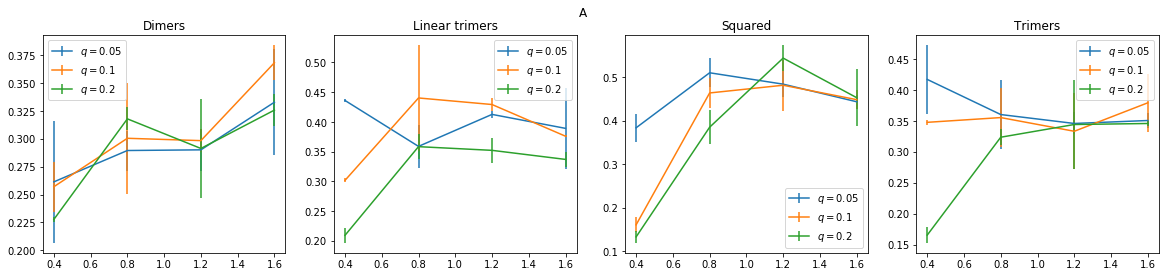

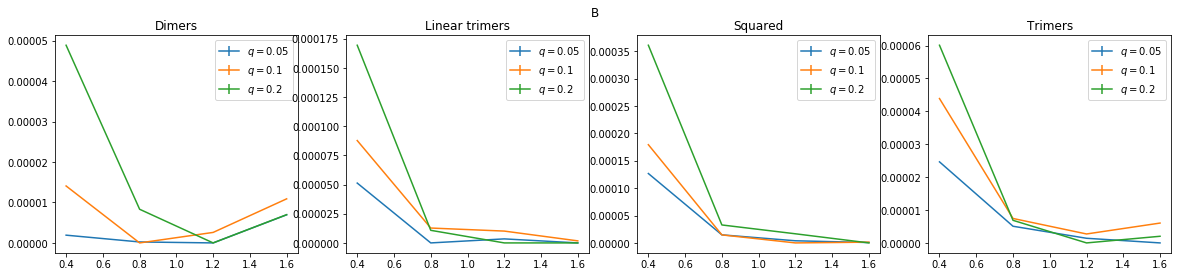

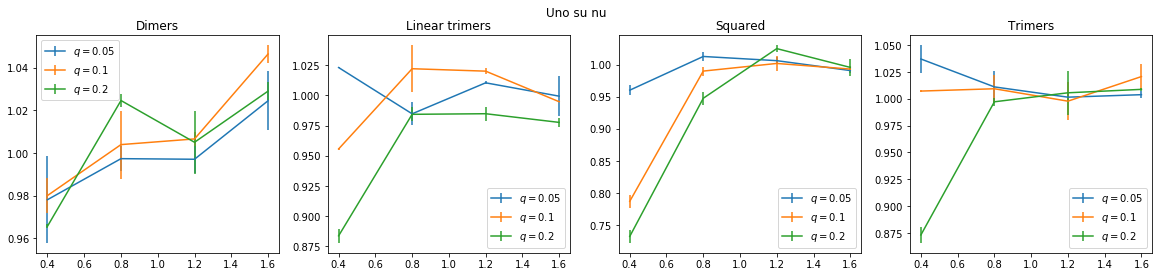

In [16]:
pdf = PdfPages( savepath + "/DeltaFitPars.pdf" )
fig = sb_init( len( polys ), 1 )

for i_p, p in enumerate( polys ):
    axes = sb( i_p+1, 1 )
    for i_q, q in enumerate( qs ):
        x = np.array([ v['gamma']   for v in fit_results if v['p'] == p and  v['q'] == q ])
        y = np.array([ v['A'] for v in fit_results if v['p'] == p and  v['q'] == q ])
        erry = np.array([ v['errA'] for v in fit_results if v['p'] == p and  v['q'] == q ])

        sort_idx = np.argsort( x )
        plt.errorbar( x[sort_idx], y[sort_idx], erry[sort_idx], color=color_list[ i_q ], label= r'$q=$' + str(q) )
    
    plt.title( p )
    plt.legend()
    plt.suptitle( 'A')

pdf.savefig()
plt.show()

fig = sb_init( len( polys ), 1 )
for i_p, p in enumerate( polys ):
    axes = sb( i_p+1, 1 )
    for i_q, q in enumerate( qs ):
        x   = np.array([ v['gamma']   for v in fit_results if v['p'] == p and  v['q'] == q ])
        y   = np.array([ v['B'] for v in fit_results if v['p'] == p and  v['q'] == q ])
        erry= np.array([ v['errB'] for v in fit_results if v['p'] == p and  v['q'] == q ])

        sort_idx = np.argsort( x )
        plt.errorbar( x[sort_idx], y[sort_idx], erry[sort_idx], color=color_list[ i_q ], label= r'$q=$' + str(q) )
    
    plt.title( p )
    plt.legend()
    plt.suptitle( 'B')

pdf.savefig()
plt.show()

fig = sb_init( len( polys ), 1 )
for i_p, p in enumerate( polys ):
    axes = sb( i_p+1, 1 )
    for i_q, q in enumerate( qs ):
        x   = np.array([ v['gamma']   for v in fit_results if v['p'] == p and  v['q'] == q ])
        y   = np.array([ v['unosunu'] for v in fit_results if v['p'] == p and  v['q'] == q ])
        erry= np.array([ v['errunosunu'] for v in fit_results if v['p'] == p and  v['q'] == q ])

        sort_idx = np.argsort( x )
        plt.errorbar( x[sort_idx], y[sort_idx], erry[sort_idx], color=color_list[ i_q ], label= r'$q=$' + str(q) )
    
    plt.title( p )
    plt.legend()
    plt.suptitle( 'Uno su nu')

pdf.savefig()
plt.show()

pdf.close()

##  Percolation studies

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


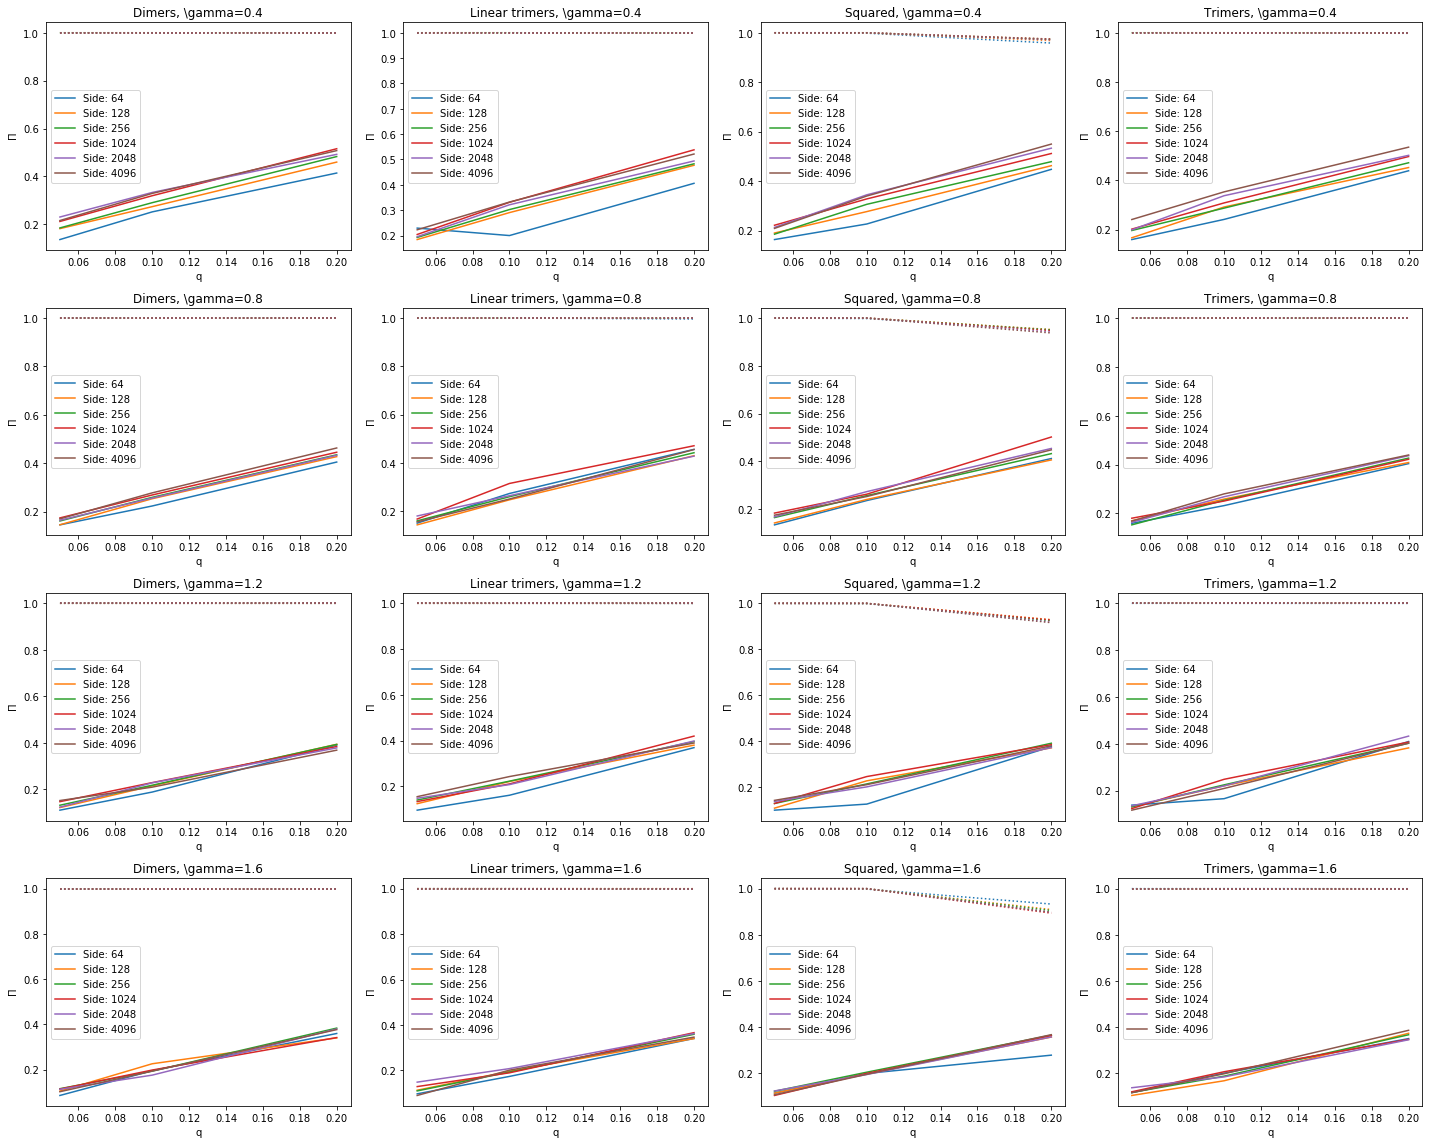

In [17]:
# Percolation probability as function of q for different values of L in different gamma and different shapes

fig = sb_init( len( polys ), len( gammas ) )

for i_p, p in enumerate( polys ):
    for i_gamma, gamma in enumerate( gammas ):
        axes = sb( i_p+1, i_gamma+1 )
        for i_side, side in enumerate( sides ):
            x = np.array([ v['defects_frac'] for v in data if v['dep_polymers'] == p and  v['gamma'] == gamma and  v['side'] == side ])
            y1= np.array([ v['defperc_avg']  for v in data if v['dep_polymers'] == p and  v['gamma'] == gamma and  v['side'] == side ])
            y2= np.array([ v['atmperc_avg']  for v in data if v['dep_polymers'] == p and  v['gamma'] == gamma and  v['side'] == side ])

            sort_idx = np.argsort( x )
            plt.plot( x[sort_idx], y1[sort_idx], '-', color=color_list[ i_side ], label= f"Side: {side}" )
            plt.plot( x[sort_idx], y2[sort_idx], ':', color=color_list[ i_side ] )
        plt.title( p + r", \gamma=" + str(gamma) )
        plt.legend()
        plt.xlabel(r'q')
        plt.ylabel(r'$\Pi$')

plt.tight_layout()